# Load checkpoint and imports

In [1]:
import sys
import warnings

import pandas as pd
import scipy
warnings.filterwarnings('ignore') 
# parent_dir = "/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024"
parent_dir="/Volumes/work/phd/MoLFormer_N2024"
sys.path.append(parent_dir)
# parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
# sys.path.append(parent_dir)

In [2]:
import pandas as pd
from utils.util_alignment import set_seeds
from utils.visualization_helper import *  
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
from constants import *
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_squared_error
plt.rc('font',**{'family':'serif','serif':['Calibri']})


base


In [3]:
# base_path= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/'
base_path= '../../../../T5 EVO/alignment_olfaction_datasets/'
results_path = 'curated_datasets/dfs_result/regression/'

In [4]:
seed = 2024
set_seeds(seed)

In [5]:
times=30
n_components=20

# Helper Methods

In [6]:
def normalize_rmse(df,min_max,j):
    max_values = min_max.max()
    min_values = min_max.min()
    min_max.columns = ['Dataset','Type']+df.columns.values.tolist()[:j]
    # Drop 'Dataset' and 'Type' as they are not numeric columns
    min_values = min_values.drop(['Dataset', 'Type'])
    max_values = max_values.drop(['Dataset', 'Type'])
    for i,col in enumerate(df.columns[:j]):
        df[col] = np.sqrt(df[col]) / (max_values[i] - min_values[i])
    return df

In [7]:
def proccess_df_for_ICC(csv_results,ds='keller',layer=13):
    
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df=pd.read_csv(base_path+results_path+csv_results)
    df = df[df['layer'] == layer]
    columns_predicted = [task+'_predicted' for task in tasks]
    columns_true= [task+'_true' for task in tasks]
    df = df.drop_duplicates(subset=['model','CID'],inplace=False)
    df_predictions = df[['model','CID']+columns_predicted]
    df_true = df[['model','CID']+columns_true]
    df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
    df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
    df_melted_true['model'] = 'subjects_average' 
    df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
    df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
    return df_concatenated

In [8]:
def proccess_df_for_Cor(csv_results,ds='keller',layer=13):

    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')

    df=pd.read_csv(base_path+results_path+csv_results)
    df = df[df['layer'] == layer]
    columns_predicted = [task+'_predicted' for task in tasks]
    columns_true= [task+'_true' for task in tasks]
    df = df.drop_duplicates(subset=['model','CID'],inplace=False)
    df_predictions = df[['model','CID']+columns_predicted]
    df_true = df[['model','CID']+columns_true]
    df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=[columns_predicted,columns_true])
    df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
    df_melted_true['model'] = 'subjects_average'
    df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
    df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
    return df_concatenated

In [9]:
# def proccess_df_for_nrmse(csv_results,ds='keller',layer=13):
#     
#     if ds=='keller':
#         tasks = keller_tasks
#     elif ds=='sagar':
#         tasks = sagar_tasks
#     else:
#         raise ValueError('Dataset not found')
#     
#     df=pd.read_csv(base_path+results_path+csv_results)
#     df = df[df['layer'] == layer]
#     columns_predicted = [task+'_predicted' for task in tasks]
#     columns_true= [task+'_true' for task in tasks]
#     df = df.drop_duplicates(subset=['model','CID'],inplace=False)
#     df_predictions = df[['model','CID']+columns_predicted]
#     df_true = df[['model','CID']+columns_true]
#     df_melted_predicted = pd.melt(df_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
#     df_melted_true = pd.melt(df_true, id_vars=['model','CID'], value_vars=columns_true)
#     df_melted_true['model'] = 'subjects_average' 
#     df_concatenated = pd.concat([df_melted_predicted, df_melted_true], axis=0)
#     df_concatenated['variable'] = df_concatenated['variable'].str.split('_', expand=True)[0]
#     return df_concatenated

In [10]:
def compute_ICC_mvm_permolecul_avgsubj(df_concatenated,model_list,model1='molformer'):
    results_dict = {}
    # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}

        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            inte_class_corr = pg.intraclass_corr(data=group, targets='CID', raters='model',ratings='value', nan_policy='omit')
            # print(variable, inte_class_corr)
            inte_class_corr['variable'] = variable
            inte_class_corr['model_2'] = model2
            results_dict[model2][variable] = inte_class_corr
            
            #save result in a dictioney with model ad variable as key
        
        
    rows = []
    for model, variables in results_dict.items():
        row = {'model_2': model}
        for variable, result in variables.items():
            row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
        rows.append(row)
    df_results = pd.DataFrame(rows)
            
            
            # dfs.append(inte_class_corr)            
    return df_results


In [11]:
def compute_correlation_mvm(df_concatenated,model_list,model1='subjects_average'):
    
    results_dict = {}
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}
        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            g1=group[group['model']==model1]
            g2=group[group['model']==model2]
            g1.drop_duplicates(subset=['CID'],inplace=True)
            
            g2 = g2.groupby('CID')['value'].mean().reset_index()
            
            g1 = g1[g1['CID'].isin(g2['CID'])]
            g2 = g2[g2['CID'].isin(g1['CID'])]
           
            g1 = g1.sort_values(by='CID')
            g2 = g2.sort_values(by='CID')
    
            corrs = scipy.stats.pearsonr(g1['value'], g2['value'])
            # corrs=pd.DataFrame([corrs.statistic],columns=['statistic'])
            # corrs['variable'] = variable
            # corrs['model_2'] = model2
            # 
            # print(variable, corrs.statistic)
            # corrs['variable'] = variable
            # corrs['model_2'] = model2
            results_dict[model2][variable] = corrs.statistic
    return pd.DataFrame(results_dict)


In [12]:
def compute_correlation_mvm_permolecul_avgsubj(df_concatenated,model_list,model1='molformer'):
    results_dict = {}
    # model2_list = ["subject_"+str(i) for i in range(1,56)]+['subjects_average']
    for model2 in model_list:
        df_concatenated_model = df_concatenated[(df_concatenated['model']==model1) | (df_concatenated['model']==model2)]
        grouped = df_concatenated_model.groupby('variable')
        results_dict[model2] = {}

        for variable, group in grouped:
            group = group.drop('variable',axis=1)
            inte_class_corr = mean_squared_error(data=group, targets='CID', raters='model',ratings='value', nan_policy='omit')
            print(variable, inte_class_corr)
            inte_class_corr['variable'] = variable
            inte_class_corr['model_2'] = model2
            results_dict[model2][variable] = inte_class_corr

            #save result in a dictioney with model ad variable as key


    rows = []
    for model, variables in results_dict.items():
        row = {'model_2': model}
        for variable, result in variables.items():
            row[variable] = result[result['Type'] == 'ICC3']['ICC'].values[0]
        rows.append(row)
    df_results = pd.DataFrame(rows)


            # dfs.append(inte_class_corr)
    return df_results


In [13]:
def plot_miguel_favorite(df_melted_true,df_melted_predicted):
    plt.figure(figsize=(80, 80))
    plt.xticks(rotation=90)
    sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_melted_true['variable'].unique()):
        category_fliers = df_melted_true[df_melted_true['variable'] == category]
        # category_fliers['value'] = abs(category_fliers['value'])
        x_positions = [i] * len(category_fliers)
        sns.scatterplot(x=x_positions, y=category_fliers['value'], color='red', s=150, marker='o')
    
    # Display the plot
    plt.show()

In [14]:
def visualoze_violinplot(df_results_all,ds,title):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    df_results_all_melt = pd.melt(df_results_all, id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    df_results_all_melt_pom = df_results_all_melt[df_results_all_melt['model_2']=='pom']
    df_results_all_melt_molformer = df_results_all_melt[df_results_all_melt['model_2']=='molformer']
    df_results_all_melt_dam = df_results_all_melt[df_results_all_melt['model_2']=='alva']
    # df_results_all_melt_subjects_average = df_results_all_melt[df_results_all_melt['model_2']=='subjects_average']
    df_results_all_melt_tov = df_results_all_melt[~df_results_all_melt['model_2'].isin(['subjects_average','molformer','pom','alva'])]
    
    
    plt.rcParams["font.size"] = 40
    f = plt.figure(figsize=(30, 20))
    g = sns.violinplot(data=df_results_all_melt_tov, x="variable", y=title,color="#d7f1f7",linewidth=2)
    g.set_xticklabels(tasks, rotation=90,size=40)
    g.set_xlabel('Descriptor', fontsize=40)
    g.set_ylabel(title, fontsize=40)
    plt.xticks(fontsize=40, rotation=90)
    plt.yticks(fontsize=40)
    
    
    # sns.boxplot(x='variable', y='value', hue='model', data=df_melted_predicted, showfliers=False)
    
    # Plot fliers using df_melted_true
    # sns.scatterplot(x='variable', y='value', data=df_melted_true, alpha=0.5)
    for i, category in enumerate(df_results_all_melt_molformer['variable'].unique()):
        category_fliers_molformer = df_results_all_melt_molformer[df_results_all_melt_molformer['variable'] == category]
        category_fliers_pom = df_results_all_melt_pom[df_results_all_melt_pom['variable'] == category]
        category_fliers_dam = df_results_all_melt_dam[df_results_all_melt_dam['variable'] == category]
        # category_fliers_subjects_average = df_results_all_melt_subjects_average[df_results_all_melt_subjects_average['variable'] == category]
        x_positions = [i] * len(category_fliers_molformer)
        
        # '#4d79a4', '#ecc947', '#b07aa0'
        
        category_fliers = pd.concat([category_fliers_molformer,category_fliers_pom,category_fliers_dam],axis=0)
        
        x_positions_all  = x_positions*3
        # print(x_positions_all,category_fliers,"sss")
       
        # sns.scatterplot(x=x_positions, y=category_fliers_molformer['ICC'], color='#4d79a4', s=1200, marker='o',label='MoLFormer')
        # sns.scatterplot(x=x_positions, y=category_fliers_pom['ICC'], color='#ecc947', s=1200, marker='o',label='Open-POM')
        # sns.scatterplot(x=x_positions, y=category_fliers_dam['ICC'], color='#b07aa0', s=1200, marker='o',label='DAM')
        colors = ['#4d79a4','#ecc947','#b07aa0','#eb4034']
        print("ssssssmmmm",x_positions_all,category_fliers)
        g = sns.scatterplot(x=x_positions_all, y=category_fliers[title],hue=category_fliers['model_2'], palette=colors , s=500, marker='o')
        
        
        g.legend().set_title("Model")
    # handles, labels = g1.get_legend_handles_labels()
        handles, labels = g.get_legend_handles_labels()
        g.get_legend().remove()
        # print(labels)
        
        labels = ['MoLFormer', 'Open-POM', 'DAM', 'Subjects Average']
        plt.rcParams["font.size"] = 40
    
        f.legend(handles, labels, ncol=4, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=(0.52, -0.2),
              frameon=True, labelspacing=0.4, handletextpad=0.2, )
        
        # print(i, x_positions,category_fliers_molformer[title],"ssssss")
        # g = sns.scatterplot(x=x_positions, y=category_fliers_subjects_average[title], color="red" , s=500, marker='_')

    
    # Display the plot
    # plt.show()
    plt.savefig('figs/'+ds + "_"+title + "_violinplott.pdf", bbox_inches='tight')
    
    

# Extracting Representations

## Keller

In [15]:
input_file_keller = base_path+'curated_datasets/mols_datasets/curated_keller2016_nona.csv' # or new downloaded file path
df_keller_temp=pd.read_csv(input_file_keller)

In [16]:
df_keller_cor_pom=pd.read_csv(base_path+results_path+"df_keller_cor_pom.csv")
df_keller_mse_pom=pd.read_csv(base_path+results_path+"df_keller_mse_pom.csv")
df_keller_cor_alva=pd.read_csv(base_path+results_path+"df_keller_cor_alva.csv")
df_keller_mse_alva=pd.read_csv(base_path+results_path+"df_keller_mse_alva.csv")
df_keller_corrs_molfomer=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomer.csv")
df_keller_mses_molfomer=pd.read_csv(base_path+results_path+"df_keller_mses_molfomer.csv")
df_keller_corrs_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_corrs_molfomerfinetuned.csv")
df_keller_mses_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_keller_mses_molfomerfinetuned.csv")

In [17]:
min_max_keller = pd.read_csv(base_path+results_path+"keller_min_max.csv")
df_keller_mse_pom=normalize_rmse(df_keller_mse_pom,min_max_keller,j=-1)
df_keller_mse_alva=normalize_rmse(df_keller_mse_alva,min_max_keller,j=-1)
df_keller_mses_molfomer=normalize_rmse(df_keller_mses_molfomer,min_max_keller,j=-2)
df_keller_mses_molfomerfinetuned=normalize_rmse(df_keller_mses_molfomerfinetuned,min_max_keller,j=-2)

['molformer', 'molformerfinetuned', 'pom', 'alva']


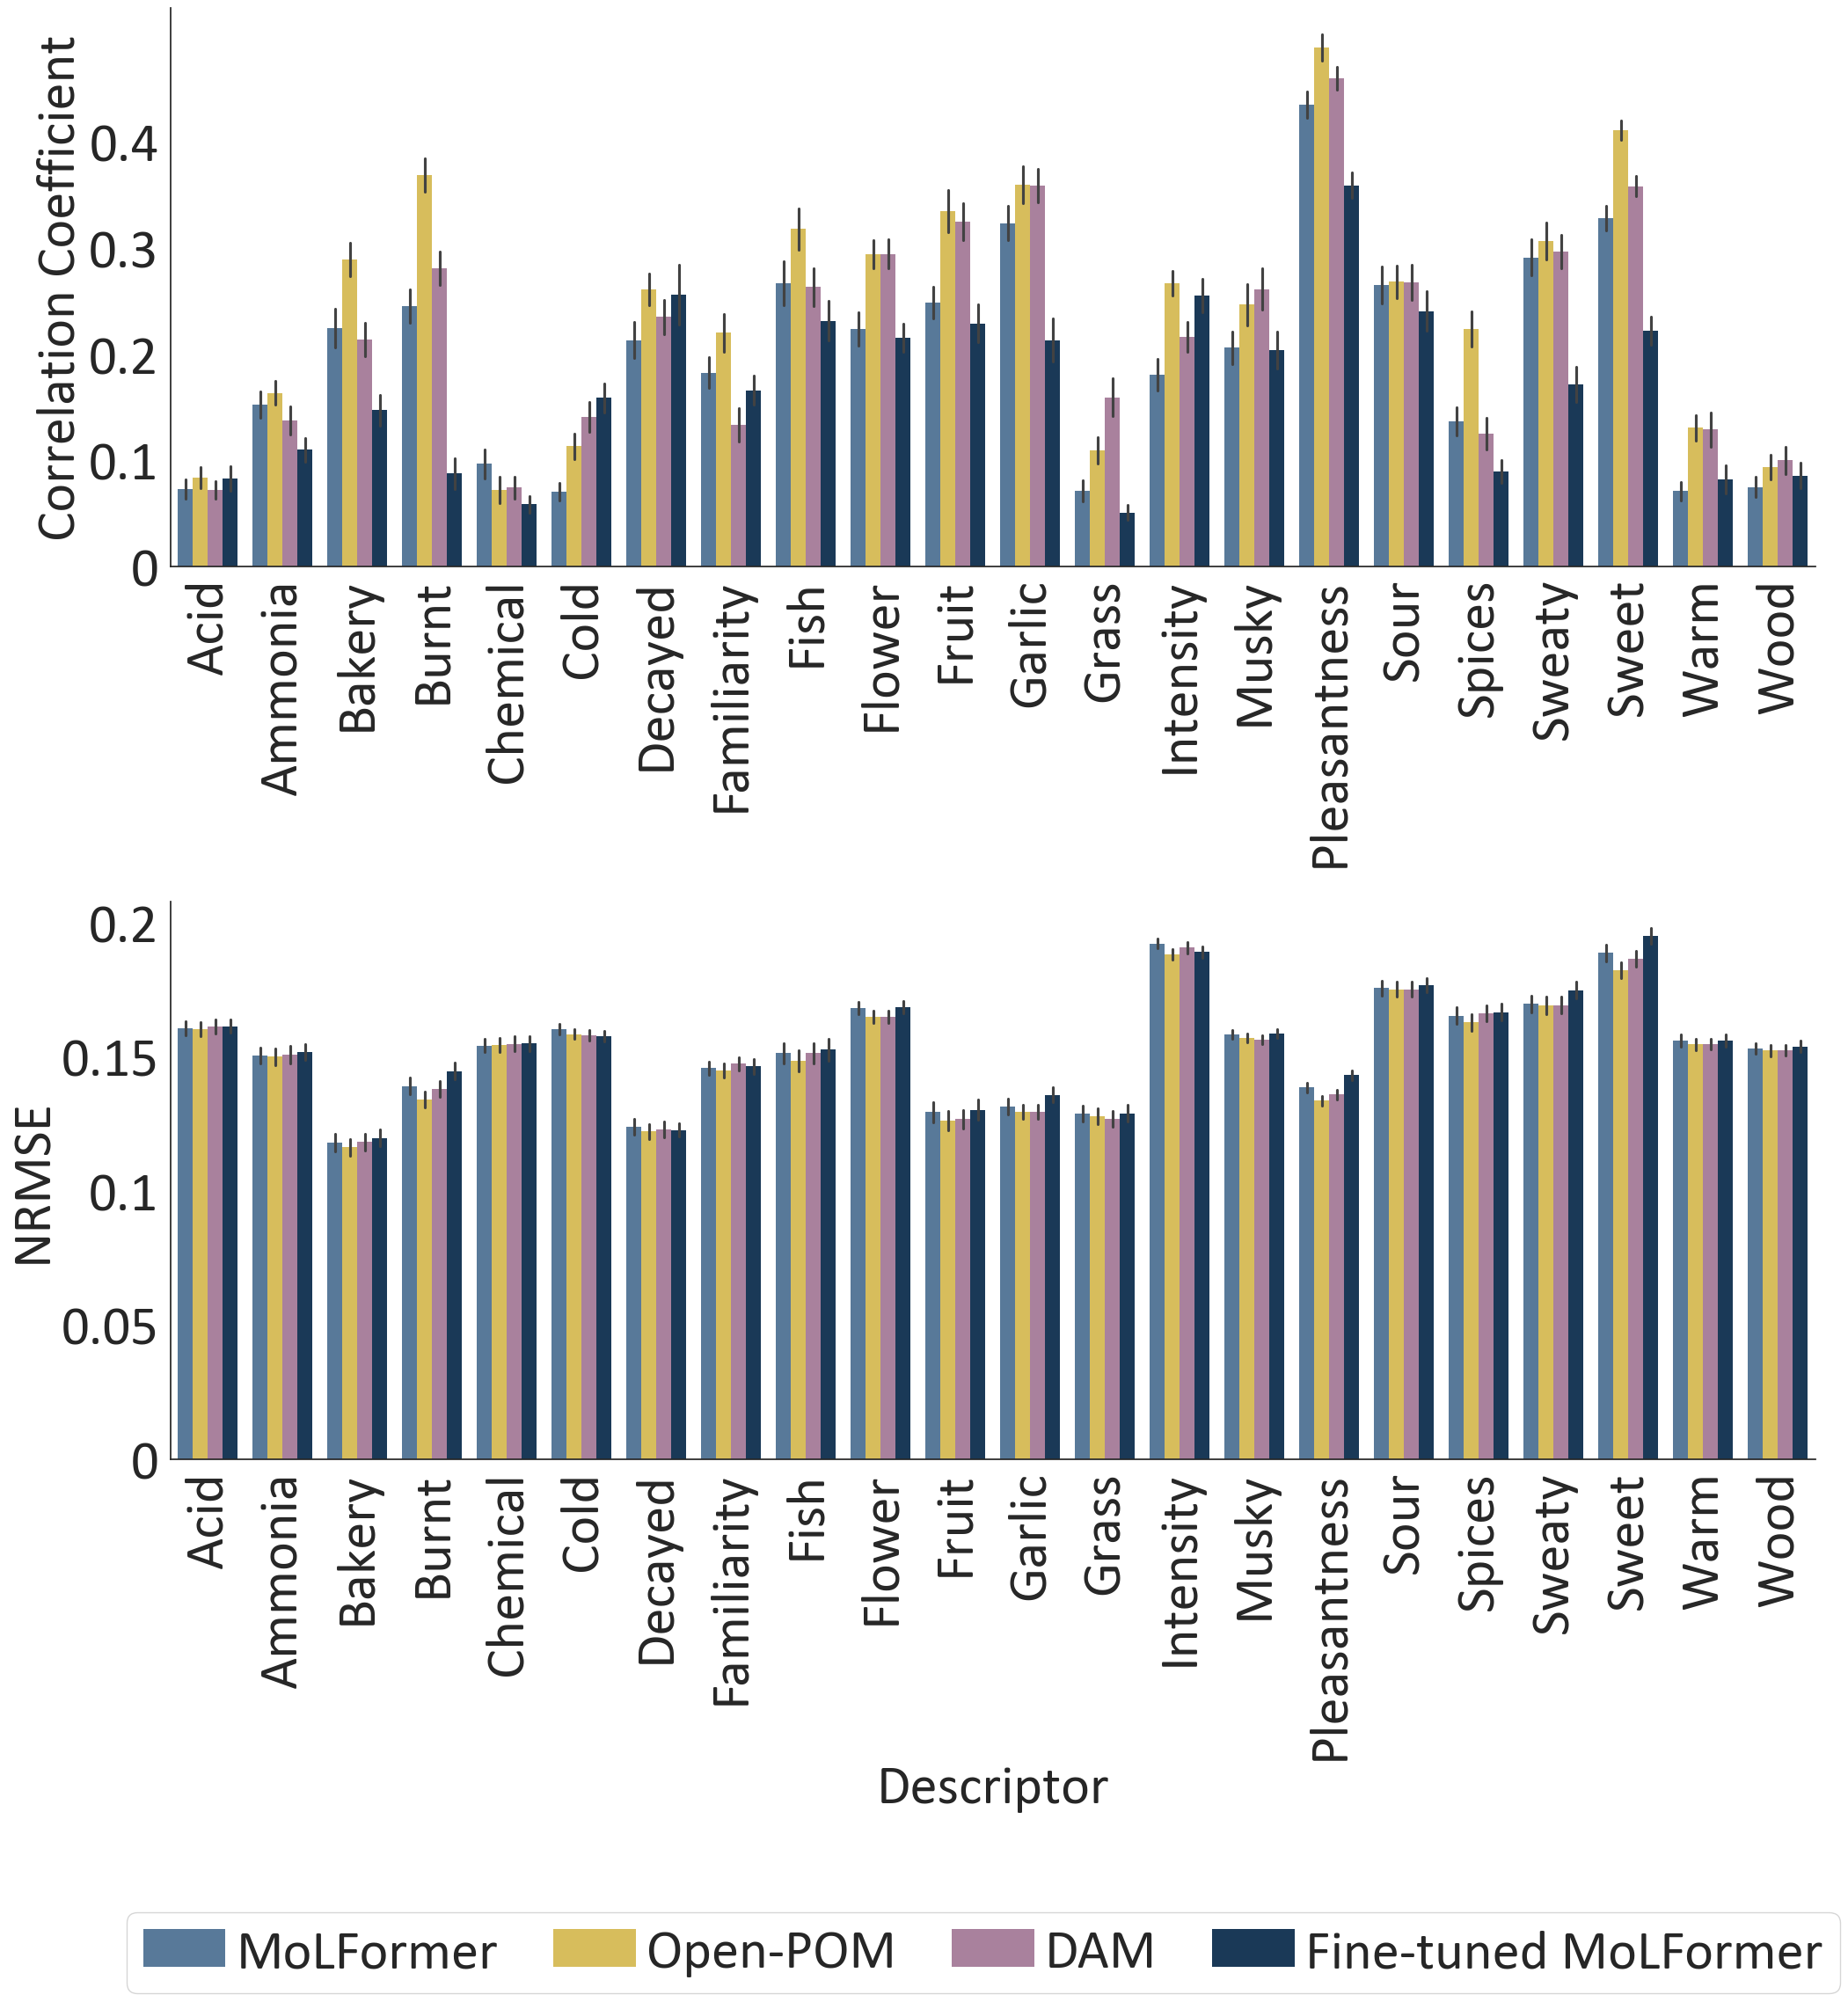

In [18]:
trend_learning_molformer =  post_process_dataframe(df_keller_corrs_molfomer,df_keller_mses_molfomer,df_keller_corrs_molfomerfinetuned,df_keller_mses_molfomerfinetuned,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva,keller_tasks,"figs/camera_ready/keller_regression_finetune",width=None,linewidth=0)
# trend_learning_molformer['dataset']='keller'

['molformer', 'pom', 'alva']


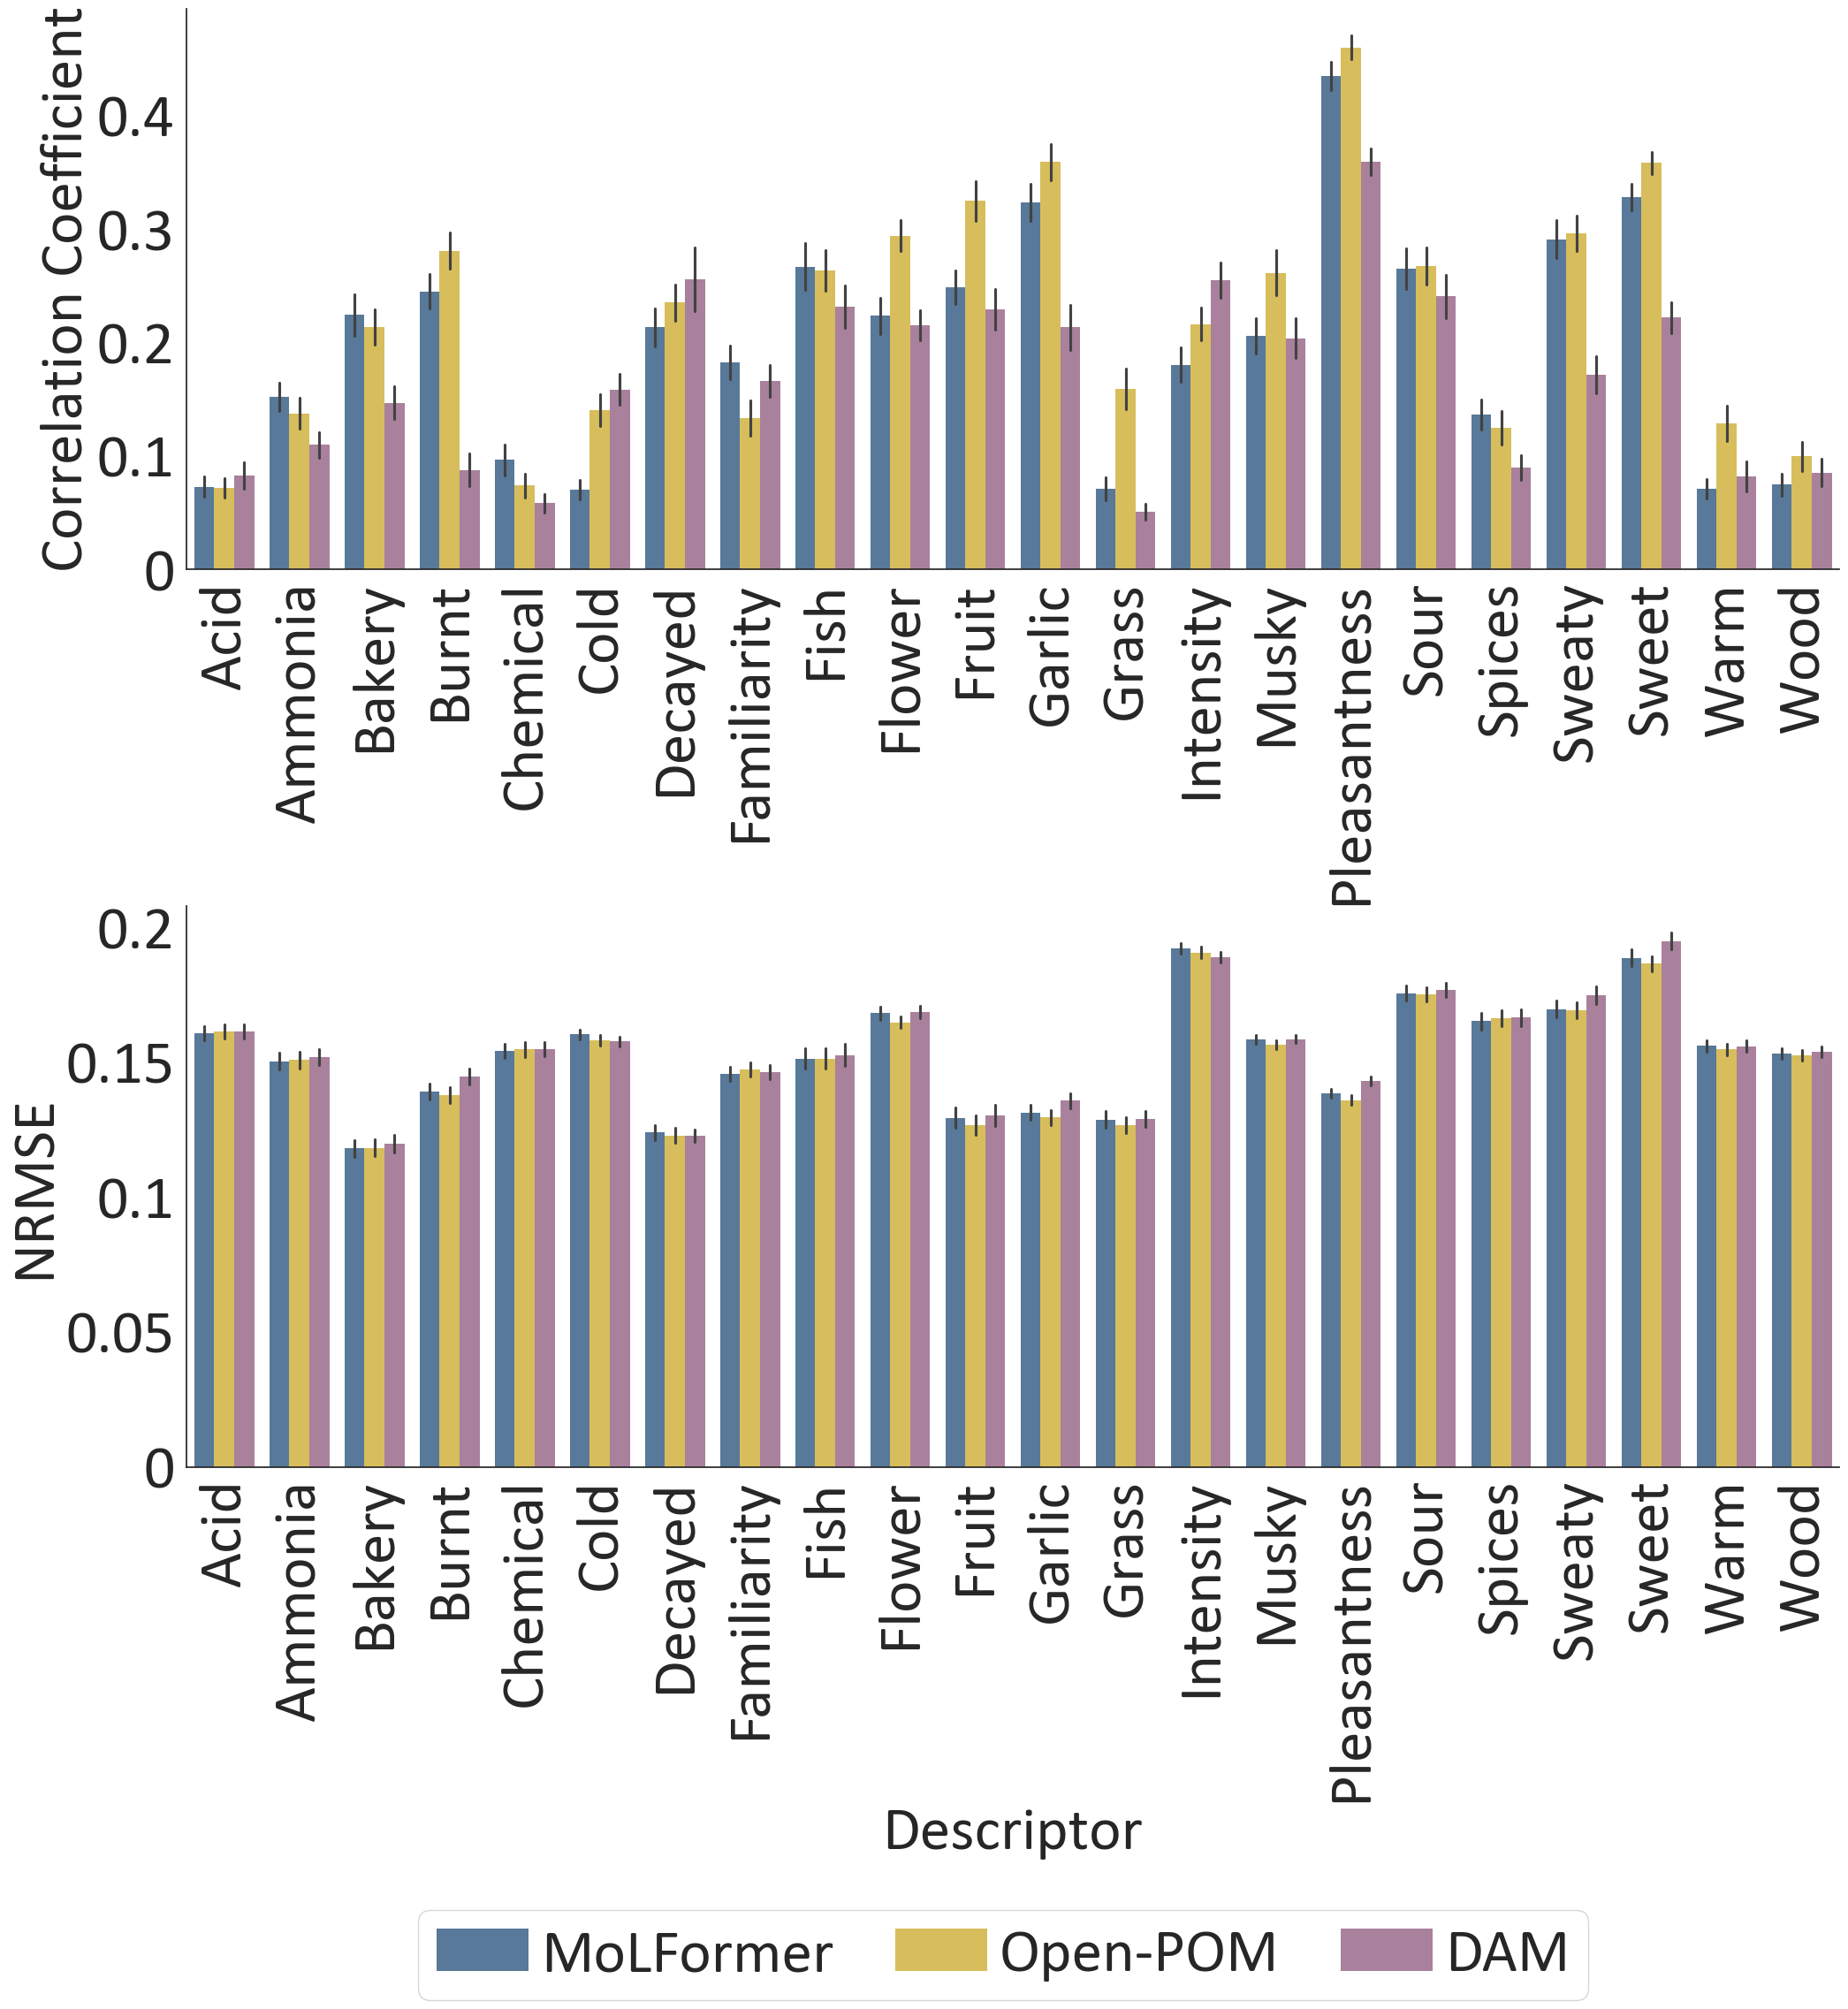

In [19]:
post_process_dataframe(df_keller_corrs_molfomer,df_keller_mses_molfomer,None,None,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva,keller_tasks,"figs/camera_ready/keller_regression",width=None,linewidth=0,fontsize=50)

In [20]:
df_concatenated_keller = proccess_df_for_ICC("keller_predictions.csv", ds='keller',layer=13)
df_keller_temp = df_keller_temp.rename(columns={'Subject': 'model'})
df_keller_subjects = df_keller_temp.melt(id_vars=['model', 'CID'], value_vars=keller_tasks, var_name='variable', value_name='value')
df_keller_subjects['model'] = df_keller_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_keller_all = pd.concat([df_concatenated_keller, df_keller_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,56)]+['molformer','pom','alva']


In [21]:
df_pivoted = df_keller_all.pivot_table(index=['CID','model'], columns=['variable'], values='value')
df_pivoted.reset_index(inplace=True)


In [22]:
def visualoze_violinplot_permol_pred(df_results_all,ds,title):    
    if ds=='keller':
        tasks = keller_tasks
        tasks = [task for task in tasks if task not in ['Intensity', 'Familiarity', 'Pleasantness']]
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    
    #suctract ['intensity', 'familiarity', 'pleasantness'] from the tasks
    
    #all columns except for 'Intensity', 'Familiarity', 'Pleasantness'
    df_results_all = df_results_all[~df_results_all['variable'].isin(['Intensity', 'Familiarity', 'Pleasantness'])]
    
    
    df_results_all_melt_pom = df_results_all[df_results_all['model']=='pom']
    df_results_all_melt_molformer = df_results_all[df_results_all['model']=='molformer']
    df_results_all_melt_dam = df_results_all[df_results_all['model']=='alva']    
    
    
    f = plt.figure(figsize=(30, 20))
    for j, mol in enumerate(df_results_all_melt_molformer['CID'].unique()):
        print(j)
        df_results_all_melt_tov = df_results_all[~df_results_all['model'].isin(['subjects_average','molformer','pom','alva'])]
        df_results_all_melt_tov = df_results_all_melt_tov[df_results_all_melt_tov['CID'] == mol]
        plt.rcParams["font.size"] = 40
        
        g = sns.violinplot(data=df_results_all_melt_tov, x="variable", y=title,color="#d7f1f7",linewidth=2)
        g.set_xticklabels(tasks, rotation=90,size=40)
        g.set_xlabel('Descriptor', fontsize=40)
        g.set_ylabel(title, fontsize=40)
        plt.xticks(fontsize=40, rotation=90)
        plt.yticks(fontsize=40)
        for i, category in enumerate(df_results_all_melt_molformer['variable'].unique()):
            print(i)
            category_fliers_molformer = df_results_all_melt_molformer[(df_results_all_melt_molformer['variable'] == category) & (df_results_all_melt_molformer['CID'] == mol )]
            category_fliers_pom = df_results_all_melt_pom[(df_results_all_melt_pom['variable'] == category) & (df_results_all_melt_pom['CID'] == mol ) ]
            category_fliers_dam = df_results_all_melt_dam[(df_results_all_melt_dam['variable'] == category) & (df_results_all_melt_dam['CID'] == mol )]
            x_positions = [i] * len(category_fliers_molformer)
            category_fliers = pd.concat([category_fliers_molformer,category_fliers_pom,category_fliers_dam],axis=0)
            x_positions_all  = x_positions*3
            colors = ['#4d79a4','#ecc947','#b07aa0','#eb4034']
            g = sns.scatterplot(x=x_positions_all, y=category_fliers[title],hue=category_fliers['model'], palette=colors , s=500, marker='o')
            handles, labels = g.get_legend_handles_labels()
            g.get_legend().remove()
            labels = ['MoLFormer', 'Open-POM', 'DAM', 'Subjects Average']
            plt.rcParams["font.size"] = 40
            f.legend(handles, labels, ncol=4, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
                  borderpad=0.3,
                  bbox_to_anchor=(0.52, -0.2),
                  frameon=True, labelspacing=0.4, handletextpad=0.2,title='Model') 
        
    
        plt.savefig('figs/'+str(mol)+'_'+ds + "_"+title + "_violinplot_predictions.pdf", bbox_inches='tight')
    
    

In [23]:
# import scipy
# df_concatenated_keller = proccess_df_for_Cor("keller_predictions.csv", ds='keller',layer=13)
# df_keller_temp = df_keller_temp.rename(columns={'Subject': 'model'})
# df_keller_subjects = df_keller_temp.melt(id_vars=['model', 'CID'], value_vars=keller_tasks, var_name='variable', value_name='value')
# df_keller_subjects['model'] = df_keller_subjects['model'].apply(lambda x: 'subject_' + str(x))
# df_keller_all = pd.concat([df_concatenated_keller, df_keller_subjects], axis=0)
# model_list = ["subject_"+str(i) for i in range(1,56)]+['molformer','pom','alva']
# 
# df_keller_all

# # df_keller = pd.read_csv(base_path+results_path+"keller_predictions.csv")
# #compute rmse for each pair of descriptor_true and descriptor_predicted
#
# # Assuming df is your DataFrame and true_cols and pred_cols are lists of your columns
# true_cols = [col for col in df_keller.columns if 'true' in col]
# pred_cols = [col for col in df_keller.columns if 'predicted' in col]
#
# rmse_results = {}
# # print(true_cols,pred_cols
# for true_col, pred_col in zip(true_cols, pred_cols):
#     df_keller[true_col.split('_')[0]+'_correlation'] =  scipy.stats.pearsonr(df_keller[true_col], df_keller[pred_col]).statistic

In [24]:
# df_keller

In [ ]:
df_results_keller_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    print(model_1)
    df_results_keller = compute_ICC_mvm_permolecul_avgsubj(df_keller_all,model_list,model1=model_1)
    df_results_keller['model_1'] = model_1
    df_results_keller_all_antonio_faviorte = pd.concat([df_results_keller_all_antonio_faviorte,df_results_keller],axis=0)

subjects_average


In [ ]:
df_results_keller

In [ ]:
# results_dict

In [ ]:
# # drop duplicated CID
# df_keller_all.drop_duplicates(subset=['CID','model'],inplace=True)
# group[(group['model']==model1) & (group['CID']==24834.0)]

In [ ]:
df_results_keller_all_corrs = pd.DataFrame()
model_list_subjects = ["subject_"+str(i) for i in range(1,56)]
for model_1 in ['subjects_average']:
    df_results_keller = compute_correlation_mvm(df_keller_all,model_list_subjects)
    # df_results_keller['model_1'] = model_1
    df_results_keller = pd.DataFrame(df_results_keller)
    df_results_keller_all_corrs = pd.concat([df_results_keller_all_corrs,df_results_keller],axis=0)
    

In [ ]:
df_results_keller_all_corrs = df_results_keller_all_corrs.T
df_results_keller_all_corrs.reset_index(inplace=True)
df_results_keller_all_corrs.rename(columns={'index':'model'},inplace=True)
df_results_keller_all_corrs.iloc[:, 1:] = df_results_keller_all_corrs.iloc[:, 1:].apply(pd.to_numeric)
average_values = df_results_keller_all_corrs.mean(numeric_only=True,skipna=True)

In [ ]:
average_values.std()#[0.20758457538023037,
#0.2064020851308793,
#0.32059218306210135,
#0.2715691179703415,
#0.27158522951724223,
#0.16675077394457594,
#0.29349601650195045,
#0.3273856825166311,
#0.21314317941624916,
#0.25842528714936563,
#0.36601663818619107,
#0.31102212563310994,
#0.24903502877353415,
#0.5263116645371589,
#0.22211075024234186,
#0.5236269660106582,
#0.2285621634179201,
#0.2404601537265736,
#0.24529944409302423,
#0.41417819277402285,
#0.16817640636878795,

In [ ]:
visualoze_violinplot(df_results_keller_all_antonio_faviorte,ds='keller',title='ICC')

In [ ]:
df_keller_all.rename(columns={'value':'prediction'},inplace=True)
visualoze_violinplot_permol_pred(df_keller_all,ds='keller',title='prediction')

In [ ]:

input_file_sagar = base_path+'curated_datasets/mols_datasets/curated_sagar_subjects_nonaminus.csv' # or new downloaded fil
df_sagar_temp=pd.read_csv(input_file_sagar)

In [ ]:
# corrs_molfomer,mses_molformer,df_keller_cor_pom,df_keller_mse_pom,df_keller_cor_alva,df_keller_mse_alva =compute_correlation_keller(times , n_components,per_descritor=False)
df_sagar_cor_pom=pd.read_csv(base_path+results_path+"df_sagar_cor_pom.csv")
df_sagar_mse_pom=pd.read_csv(base_path+results_path+"df_sagar_mse_pom.csv")
df_sagar_cor_alva=pd.read_csv(base_path+results_path+"df_sagar_cor_alva.csv")
df_sagar_mse_alva=pd.read_csv(base_path+results_path+"df_sagar_mse_alva.csv")
df_sagar_corrs_molfomer=pd.read_csv(base_path+results_path+"df_sagar_corrs_molfomer.csv")
df_sagar_mses_molfomer=pd.read_csv(base_path+results_path+"df_sagar_mses_molfomer.csv")
df_sagar_corrs_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_sagar_corrs_molfomerfinetuned.csv")
df_sagar_mses_molfomerfinetuned=pd.read_csv(base_path+results_path+"df_sagar_mses_molfomerfinetuned.csv")


In [ ]:
min_max_sagar = pd.read_csv(base_path+results_path+"sagar_min_max.csv")
df_sagar_mse_pom=normalize_rmse(df_sagar_mse_pom,min_max_sagar,j=-1)
df_sagar_mse_alva=normalize_rmse(df_sagar_mse_alva,min_max_sagar,j=-1)
df_sagar_mses_molfomer=normalize_rmse(df_sagar_mses_molfomer,min_max_sagar,j=-2)
df_sagar_mses_molfomerfinetuned=normalize_rmse(df_sagar_mses_molfomerfinetuned,min_max_sagar,j=-2)


In [ ]:
trend_learning_molformer_sagar = post_process_dataframe(df_sagar_corrs_molfomer,df_sagar_mses_molfomer,df_sagar_corrs_molfomerfinetuned,df_sagar_mses_molfomerfinetuned,df_sagar_cor_pom,df_sagar_mse_pom,df_sagar_cor_alva,df_sagar_mse_alva,sagar_tasks,"figs/sagar_regression",width=0.21)

In [ ]:
df_concatenated_sagar = proccess_df_for_ICC("sagar_predictions.csv", ds='sagar',layer=13)
df_sagar_temp = df_sagar_temp.rename(columns={'subject': 'model', 'cid': 'CID'})
df_sagar_subjects = df_sagar_temp.melt(id_vars=['model', 'CID'], value_vars=sagar_tasks, var_name='variable', value_name='value')
df_sagar_subjects['model'] = df_sagar_subjects['model'].apply(lambda x: 'subject_' + str(x))
df_sagar_all = pd.concat([df_concatenated_sagar, df_sagar_subjects], axis=0)
model_list = ["subject_"+str(i) for i in range(1,4)]+['molformer','pom','alva']

In [ ]:
df_results_sagar_all_antonio_faviorte = pd.DataFrame()
for model_1 in ['subjects_average']:
    df_results_sagar = compute_ICC_mvm_permolecul_avgsubj(df_sagar_all,model_list,model1=model_1)
    df_results_sagar['model_1'] = model_1
    df_results_sagar_all_antonio_faviorte = pd.concat([df_results_sagar_all_antonio_faviorte,df_results_sagar],axis=0)

In [45]:
df_results_sagar_all_corrs = pd.DataFrame()
model_list_subjects = ["subject_"+str(i) for i in range(1,4)]
for model_1 in ['subjects_average']:
    df_results_sagar = compute_correlation_mvm(df_sagar_all,model_list_subjects)
    # df_results_keller['model_1'] = model_1
    df_results_sagar = pd.DataFrame(df_results_sagar)
    df_results_sagar_all_corrs = pd.concat([df_results_sagar_all_corrs,df_results_sagar],axis=0)
    

In [46]:
df_results_sagar_all_corrs = df_results_sagar_all_corrs.T
df_results_sagar_all_corrs.reset_index(inplace=True)
df_results_sagar_all_corrs.rename(columns={'index':'model'},inplace=True)
df_results_sagar_all_corrs.iloc[:, 1:] = df_results_sagar_all_corrs.iloc[:, 1:].apply(pd.to_numeric)
average_values = df_results_sagar_all_corrs.mean(numeric_only=True,skipna=True)

In [49]:
average_values.std()

0.05011134348030704

In [3]:
visualoze_violinplot(df_results_sagar_all_antonio_faviorte,ds='sagar',title='ICC')

NameError: name 'visualoze_violinplot' is not defined

In [ ]:
# df_sagar=pd.read_csv(base_path+results_path+'sagar_predictions.csv')
# columns_predicted = [task+'_predicted' for task in sagar_tasks]
# columns_true= [task+'_true' for task in sagar_tasks]
# df_sagar_predictions = df_sagar[['model','CID']+columns_predicted]
# df_sagar_true = df_sagar[['model','CID']+columns_true]
# df_sagar_melted_predicted= pd.melt(df_sagar_predictions, id_vars=['model','CID'], value_vars=columns_predicted)
# df_sagar_melted_true = pd.melt(df_sagar_true, id_vars=['model','CID'], value_vars=columns_true)

In [4]:
# for cid in df_sagar_melted_predicted['CID'].unique():
#     df_sagar_melted_predicted[df_sagar_melted_predicted['CID']==cid]
# plot_miguel_favorite(df_sagar_melted_true,df_sagar_melted_predicted)

In [5]:
def plot_ICC_resutls(df,ds):
    if ds=='keller':
        tasks = keller_tasks
    elif ds=='sagar':
        tasks = sagar_tasks
    else:
        raise ValueError('Dataset not found')
    df_melted = df.melt(id_vars=['model_1', 'model_2'], value_vars=tasks, var_name='variable', value_name='ICC')
    
    # Create the scatter plot
    f = plt.figure(figsize=(35, 6))
    g = sns.scatterplot(data=df_melted, x='variable', y='ICC', hue='model_2', style='model_1',s=100,alpha=0.5)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)
    handles, labels = g.get_legend_handles_labels()
    g.get_legend().remove()
    print("labels",labels)
    f.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.95)
    labels = ['','','','','','Model','MoLFormer', 'Open-POM', 'DAM']
    f.legend(handles[-3:], labels[-3:], ncol=3, columnspacing=1, prop={'size': 40}, handlelength=1.5, loc="lower center",
              borderpad=0.3,
              bbox_to_anchor=(0.52, -0.7),
              frameon=True, labelspacing=0.4, handletextpad=0.2, )
    # plt.legend(title='Smoker', loc='upper left',)
    plt.subplots_adjust(hspace=0.6)
    f.savefig("ICC_"+ds + ".pdf", bbox_inches='tight')
    # Show the plot
    plt.show()

In [6]:
df_results_sagar_subjects = df_results_sagar_all[df_results_sagar_all['model_2']!='subjects_average']
plot_ICC_resutls(df_results_sagar_subjects,'sagar')
df_results_sagar_subjects = df_results_sagar_subjects.drop('model_2',axis=1)
#compute average over all the subjects
df_results_sagar_subjects.groupby('model_1').mean()
# df_results_sagar_subjects.groupby('model_1').select_dtypes(include=[np.number]).mean()


NameError: name 'df_results_sagar_all' is not defined

In [ ]:
plot_ICC_resutls(df_results_keller_all,'keller')

In [ ]:
# f2, ax = plt.subplots(2, 1, figsize=(22, 22))
# g1 = combine_visualize((df_results_keller[df_results_keller['model']=='molformer'], df_results_keller[df_results_keller['model']=='pom'],
#                            df_results_keller[df_results_keller['model']=='alva']), keller_tasks, ax[0], 'ICC',
#                            figure_name='ICC',abs=True)
# 
# g2= combine_visualize((df_results_sagar[df_results_sagar['model']=='molformer'], df_results_sagar[df_results_sagar['model']=='pom'],
#                             df_results_sagar[df_results_sagar['model']=='alva']), sagar_tasks, ax[1], 'ICC',
#                             figure_name='ICC',abs=True)
# 
# vertical_plot_tweak(f2, 'ICC', g1, g2)


In [ ]:

grouped_predicted = df_concatenated.groupby('variable')
# Initialize an empty dictionary to store the results
kappa_scores = {}

# For each group in group_predicted, compute interclass_corr between 

for (var_predicted) in zip(df_concatenated):
    pg.intraclass_corr(data=var_predicted, targets='value', raters='model',
                         ratings='Scores')
    
    # pg.intraclass_corr()
    # kappa = cohen_kappa_score(group_predicted['value'], group_true['value'])
    # kappa_scores[var_predicted] = kappa

# Print the results
for variable, kappa in kappa_scores.items():
    print(f"Cohen's kappa for {variable}: {kappa}")




#inter-rater agreement for pair of molecules

In [ ]:
# we want to plot m plots which m is the number of molecules in the dataset. for eah molecule we have n boxplot which is n tasks. boxplot show the distribution over subjects and we show the prediction as a line in the boxplot. We average over all the runs available in ds results.


#plot a boxplot for the average over all the tasks per _predicted descriptor_ 

#define plot_boxplot function
#plot a boxplot for the average over all the tasks per _predicted descriptor_
# def plot_boxplot(df, tasks, dataset):
#     for i in range(len(df)):
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(data=df.iloc[i], showfliers=False)
#         plt.title(f'{dataset} - {tasks[i]}')
#         plt.xlabel('Subjects')
#         plt.ylabel('Predicted Value')
#         plt.show()
#            
# plot_boxplot(df_keller_predictions,keller_tasks,"keller_regression")

In [1]:
cohen_kappa_score(df_keller_predictions_lastlayer_notruedduplicate['LogP_true'],df_keller_predictions_lastlayer_notruedduplicate['LogP_predicted'])

NameError: name 'cohen_kappa_score' is not defined

 Sagar